In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp

In [2]:
from GraphST import GraphST

In [3]:
# Run device, by default, the package is implemented on 'cpu'. We recommend using GPU.
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# the location of R, which is necessary for mclust algorithm. Please replace the path below with local R installation path
os.environ['R_HOME'] = 'C:/Users/AGNISH/.conda/envs/GraphST/Lib/R/'

In [51]:
# the number of clusters
n_clusters = 7

In [5]:
dataset = 'Spatial_Proteogenomics_GSM_5764423'

In [26]:
# input_dir = 'C:/Users/AGNISH/Desktop/IITK/VSCode/GraphST/151673/'
# adata = sc.read_10x_h5(input_dir +'filtered_feature_bc_matrix.h5')
# adata.var_names_make_unique()

# read data
file_fold = 'C:/Users/AGNISH/GraphST/Data/' + str(dataset) #please replace 'file_fold' with the download path
temp = sc.read_visium(file_fold, count_file='GSM5764423_filtered_feature_bc_matrix_BH001.h5', load_images=True)
temp.var_names_make_unique()

c:\Users\AGNISH\.conda\envs\GraphST\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [27]:
input_dir = 'C:/Users/AGNISH/GraphST/Data/' + str(dataset) #please replace 'file_fold' with the download path
adata = sc.read_csv(input_dir + '/GSM5764423_counts_ADT_BH001_transpose.csv', delimiter=",", dtype='float32')
adata.obs_names = [id + "-1" for id in adata.obs_names]  # Add "-1" to all identifiers in adata.obs
adata.var_names_make_unique()

In [28]:
temp

AnnData object with n_obs × n_vars = 1708 × 31053
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [29]:
adata

AnnData object with n_obs × n_vars = 1698 × 93

In [30]:
def compare_obs_unique_ids(adata1, adata2):
    """
    Compare unique row identifier values between two AnnData objects' .obs attribute.

    Args:
        adata1 (anndata.AnnData): First AnnData object.
        adata2 (anndata.AnnData): Second AnnData object.

    Returns:
        set: Set of unique row identifier values present in both adata1.obs and adata2.obs.
    """
    obs_ids1 = set(adata1.obs.index.tolist())
    obs_ids2 = set(adata2.obs.index.tolist())
    common_ids = obs_ids1.intersection(obs_ids2)
    return common_ids

# Example usage:
# Assuming you have two AnnData objects, adata and temp, with .obs attribute containing row identifiers.


def filter_common_rows(adata1, adata2):
    """
    Filter two AnnData objects and keep only the rows with common unique identifiers.

    Args:
        adata1 (anndata.AnnData): First AnnData object.
        adata2 (anndata.AnnData): Second AnnData object.

    Returns:
        tuple: Tuple of filtered AnnData objects, (filtered_adata1, filtered_adata2).
    """
    common_ids = compare_obs_unique_ids(adata1, adata2)  # Assuming you have the compare_obs_unique_ids function from the previous code

    # Convert common_ids set to list
    common_ids = list(common_ids)

    filtered_adata1 = adata1[common_ids]
    filtered_adata2 = adata2[common_ids]

    return filtered_adata1, filtered_adata2

# Example usage:
# Assuming you have two AnnData objects, adata and temp, with .obs attribute containing row identifiers.

In [31]:
adata, temp = filter_common_rows(adata, temp)

In [32]:
adata

View of AnnData object with n_obs × n_vars = 1698 × 93

In [33]:
adata.obsm=temp.obsm

In [34]:
adata.uns=temp.uns

In [35]:
adata

AnnData object with n_obs × n_vars = 1698 × 93
    uns: 'spatial'
    obsm: 'spatial'

In [36]:
adata.obs

""
GCGAGGCCCGAGCAGA-1
TTATAGGTAATTGTCT-1
AGCAGAAGGAGAAAGA-1
CTCACATTTACTAAAT-1
CATCATTACCCTGAGG-1
...
TTGATTATGCAGATGA-1
GGTTAGGCTTGGAGAA-1
TCCTTTAAATCCGCTT-1
GGTTAGCTATATGTCT-1


In [37]:
adata.var

""
CD4
CD8a
CD117
Ly6C
CD11b-mh
...
CD270
CD2
CD31
CD107a


In [38]:
# define model
model = GraphST.GraphST(adata, device=device)

# train model
adata = model.train()

Begin to train ST data...


100%|██████████| 600/600 [00:58<00:00, 10.27it/s]

Optimization finished for ST data!


In [39]:
adata

AnnData object with n_obs × n_vars = 1698 × 93
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb'

In [52]:
# set radius to specify the number of neighbors considered during refinement
radius = 50

tool = 'mclust' # mclust, leiden, and louvain

# clustering
from GraphST.utils import clustering

if tool == 'mclust':
   clustering(adata, n_clusters, radius=radius, method=tool, refinement=True) # For DLPFC dataset, we use optional refinement step.
elif tool in ['leiden', 'louvain']:
   clustering(adata, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False)

fitting ...
  |======================================================================| 100%


In [24]:
# add ground_truth
df_meta = pd.read_csv(file_fold + '/metadata.tsv', sep='\t')
df_meta_layer = df_meta['layer_guess']
adata.obs['ground_truth'] = df_meta_layer.values

In [25]:
# filter out NA nodes
adata = adata[~pd.isnull(adata.obs['ground_truth'])]

# calculate metric ARI
ARI = metrics.adjusted_rand_score(adata.obs['domain'], adata.obs['ground_truth'])
adata.uns['ARI'] = ARI

print('Dataset:', dataset)
print('ARI:', ARI)

c:\Users\AGNISH\.conda\envs\GraphST\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


Dataset: 151673
ARI: 0.6331903767517718


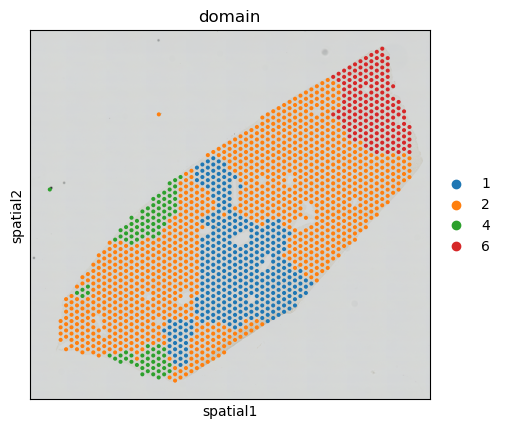

In [53]:
# plotting spatial clustering result
sc.pl.spatial(adata,
              img_key="hires",
              #color=["ground_truth", "domain"],
              color=["domain"],
              #title=["Ground truth", "ARI=%.4f"%ARI],
              show=True)

c:\Users\AGNISH\.conda\envs\GraphST\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'Predicted labels'}, xlabel='UMAP1', ylabel='UMAP2'>

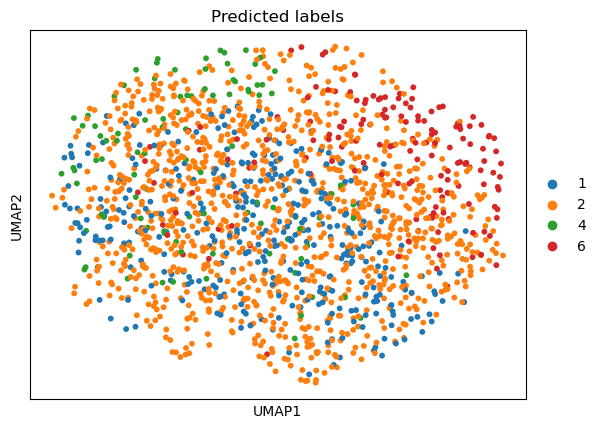

In [54]:
# plotting predicted labels by UMAP
sc.pp.neighbors(adata, use_rep='emb_pca', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color='domain', title=['Predicted labels'], show=False)